In [3]:
import numpy as np
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, shapiro, ks_2samp
import seaborn as sns
#BIG ISSUES: Classifier for CAHOOTS/CAD data, will require high quality data set to be created.
#            
#How well do these two data sets line up:
#Systemic dif: Demographic inforemation is not found in the CAD data set, CAHOOTS data set and CAD data times do not line up. 1/2 of call data found in the month of december of 2023 is only in one cad dataset
#Occasional dif: Time when call is created/dispatched/routed is not clear, this could be an occasional diff. Month? (maybe mean of days?) Mean Calls table
#further reading: (on concordance and agreement) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5654219/#:~:text=Often%2C%20one%20is%20interested%20in,concordance%20or%20reproducibility%20between%20measurements.
#current research questions to look

In [5]:
cad_16 = pd.read_csv("call_data_from_CAD_clean.csv") #CAD16
cad_df = pd.read_csv("call_data_from_CAD_2022_clean.csv") #CAD22
cahoot_df = pd.read_csv("call_data_from_CAHOOTS_clean.csv") #CAHOOTS23
cahoot_22 = pd.read_csv("call_data_cahoots_21_22_clean.csv") #CAHOOTS22

Index(['Incident Number', 'Incident Call Time', 'City', 'Assigned Unit',
       'Service Type', 'Agency', 'First Unit Dispatched',
       'First Dispatched Timestamp', 'First Enroute Timestamp',
       'First Arrived Timestamp', 'First Transport Timestamp',
       'Last Unit Clear Timestamp', 'Hold Time', 'Time Finished',
       'Time Routed', 'Time Ready', 'Primary Unit', 'Time Closed'],
      dtype='object')

In [6]:
#This cell will pick out the cahoots calls from the cad data
#I found CAHOT as a call sign in both CAD datasets, beware the text is followed with spaces so do an str replace, 
#going off what Rori said about all J units i found: 
#['4J79      ' '1J77      ' '3J78      ' '4J79  ' '1J77  ' '3J78  '] as Cahoots signs in the 2022 CAD dataset (+ "CAHOT  ") and 
#['3J79' '3J78' '3J77' '1J77' '4J79' '3J81' '3J76' '2J28' '2J29'] (+ "CAHOT  ") in the larger CAD dataset
cad_df_WCH_1 = cad_df[cad_df["Assigned Unit"].isin(["CAHOT", "1J77", "3J78","4J79"])]
len(cad_df_WCH_1) #6757
len(cad_df) #12492
cad_df_WCH_2 = cad_df[cad_df["Primary Unit"].isin(["CAHOT", "1J77", "3J78","4J79"])]
len(cad_df_WCH_2) #7487
cad_df_WCH_3 = cad_df[cad_df["Agency"] == 'CAHE']
len(cad_df_WCH_3) #7487
#cad_df_WCH["Primary Unit"].isna()
cad_df_WCH = cad_df_WCH_3
cad_df_WCH.columns #Data frame of cad_df with all identifiable cahoots call

##############################

cad_16_NNA = cad_16[cad_16["PrimaryUnitCallSign"].isna() == False] #271917 
sum(cad_16_NNA["RespondingUnitCallSign"].isna()) #309065
cad_16_WCH_1 = cad_16[cad_16["PrimaryUnitCallSign"].isin(['3J79','3J78','3J77','1J77','4J79','3J81','3J76','2J28','2J29', 'CAHOT'])] #121923 
cad_16_WCH_2 = cad_16[cad_16["RespondingUnitCallSign"].isin(['3J79','3J78','3J77','1J77','4J79','3J81','3J76','2J28','2J29', 'CAHOT'])]
#99358 
cad_16_WCH = cad_16_WCH_1
len(cad_16_WCH["Call_Created_Time"].unique()) #109764 #toatle number of call = 121923
cad_16_WCH.sort_values(by="Call_Created_Time")
mask = (cad_16["PrimaryUnitCallSign"].isin(['3J79','3J78','3J77','1J77','4J79','3J81','3J76','2J28','2J29', 'CAHOT']) | cad_16["RespondingUnitCallSign"].isin(['3J79','3J78','3J77','1J77','4J79','3J81','3J76','2J28','2J29', 'CAHOT']))
cad_16_WCH = cad_16.loc[mask]


C:\Users\charl\AppData\Local\Temp\ipykernel_14588\1012747055.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cad_16_WCH["Call_Created_Time"] = cad_16_WCH["Call_Created_Time"].astype("datetime64[ns]")


a


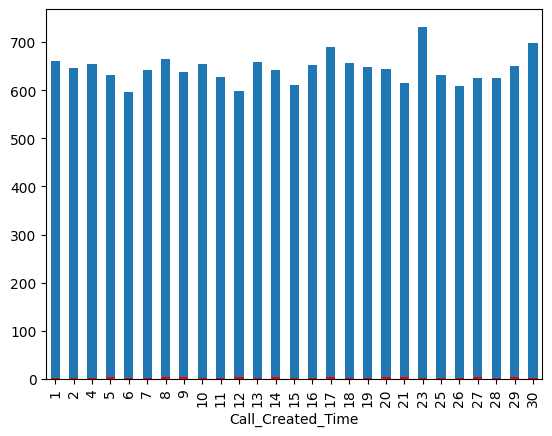

In [11]:
#
#make a table/plots of months of activity between cad/cahoots
#cad_16 & cahoots_df 2023-01-01 - 2023-12-31
cahoot_df.sort_values(by="TimeOfCall")
mask = (cad_16_WCH["Call_Created_Time"] >= '2023-01-01 00:00:00') #only 58 calls found in the cad_16 dataset past 23-01-01 
len(cad_16_WCH.loc[mask])


#
cahoot_df["TimeOfCall"] = cahoot_df["TimeOfCall"].astype("datetime64[ns]")
ax = cahoot_df["TimeOfCall"].groupby(cahoot_df["TimeOfCall"].dt.day).count().plot(kind="bar")
cad_16_WCH["Call_Created_Time"] = cad_16_WCH["Call_Created_Time"].astype("datetime64[ns]")
cad_16_WCH.loc[mask]["Call_Created_Time"].groupby(cad_16_WCH.loc[mask]["Call_Created_Time"].dt.day).count().plot(kind="bar", color="red")
cahoot_df.sort_values(by="TimeOfCall")
print("a")

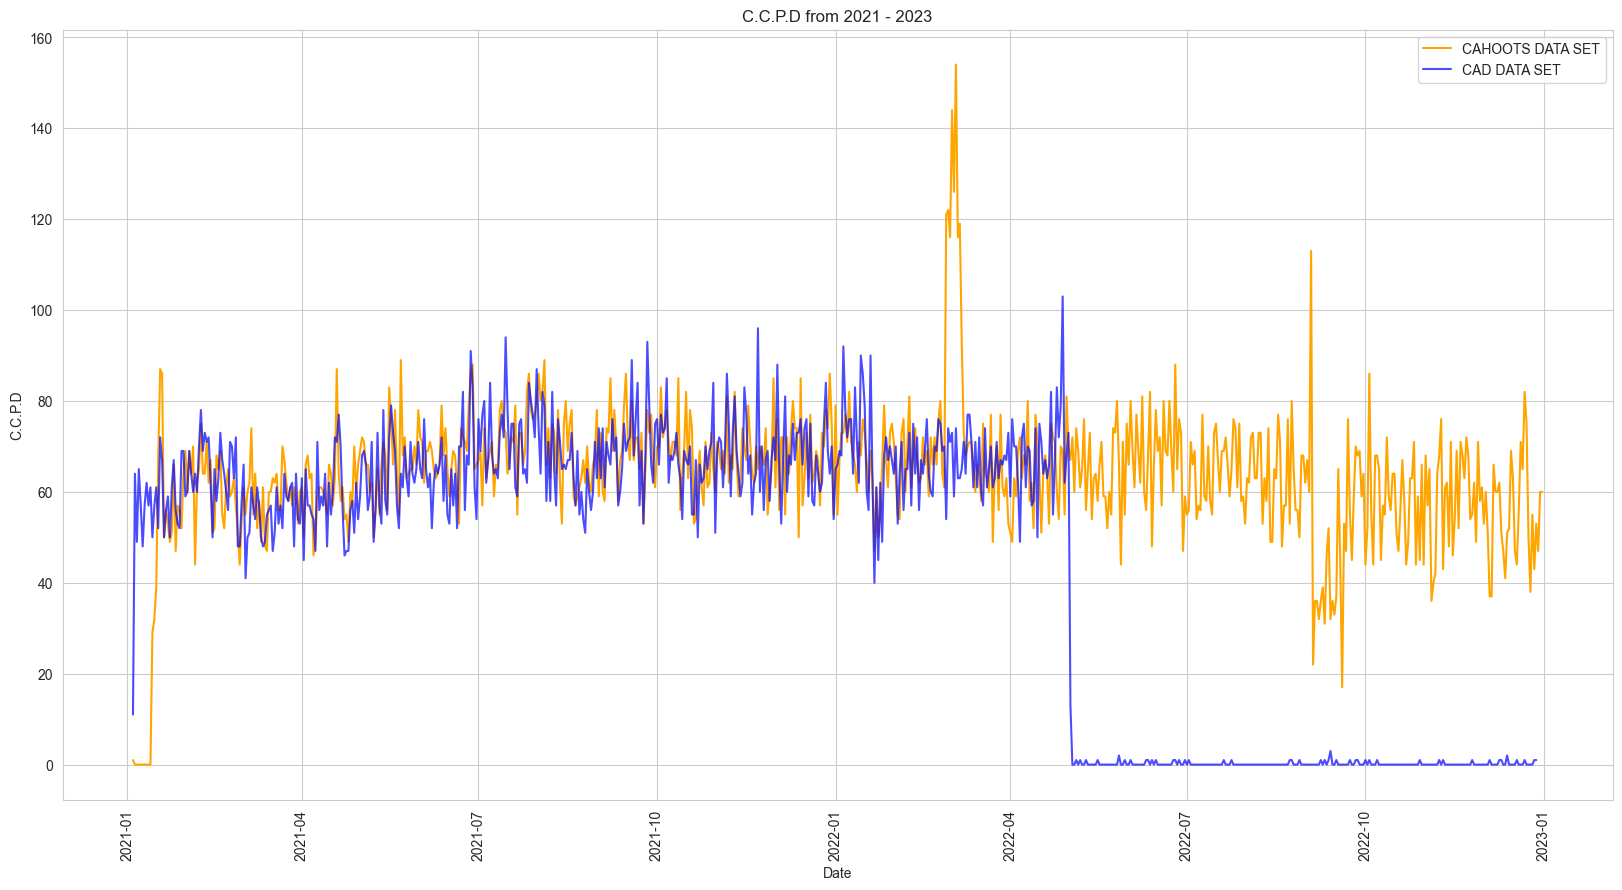

In [232]:
## cad_16_WCH and cahoot_22
cahoot_22.sort_values(by="TimeOfCall") # earliest time 2021-01-04 20:10:31 latest time 2022-12-31 22:33:24
mask2 = ((cad_16_WCH["Call_Created_Time"] >= '2021-01-04 20:10:31') & (cad_16_WCH["Call_Created_Time"] < '2023-01-01 00:00:00'))
cad_21 = cad_16_WCH.loc[mask2].sort_values(by="Call_Created_Time")
cad_21 #for comparison with cahoot_22
cad_x = cad_21["Call_Created_Time"].groupby(cad_21["Call_Created_Time"].dt.month).count()
cahoot_22["TimeOfCall"] = cahoot_22["TimeOfCall"].astype("datetime64[ns]")
cah_x = cahoot_22["TimeOfCall"].groupby(cahoot_22["TimeOfCall"].dt.month).count()

cah_x[0:].tolist()
cad_x.tolist()
cad_x.tolist()
#plt.plot(range(0,12), cad_x.tolist())
#plt.plot(range(0,12), cah_x.tolist())
#plt.plot(cahoot_22["TimeOfCall"].tolist())
cah_t = cahoot_22["TimeOfCall"]
cah_t_df = pd.DataFrame(data=cah_t)
cah_t_df.set_index("TimeOfCall",inplace=True)
daily_counts_cah = cah_t_df.resample("D").size()
cad_t = cad_21["Call_Created_Time"]
cad_t_df = pd.DataFrame(data=cad_t)
cad_t_df.set_index("Call_Created_Time", inplace=True)
daily_counts_cad = cad_t_df.resample("D").size()
plt.figure(figsize=(20, 10))
plt.xticks(rotation="vertical")
plt.plot(daily_counts_cah, label="CAHOOTS DATA SET", color="orange")
plt.plot(daily_counts_cad, label="CAD DATA SET", color="blue",alpha=.7)
plt.legend()
plt.title("C.C.P.D from 2021 - 2023")
plt.xlabel("Date")
plt.ylabel("C.C.P.D")
plt.savefig("CCCPT_TIME.png", dpi=300)

In [52]:
####
#Wilcox signed rank test, first need to conver the populations into an apporpriate time scale
pop1 = daily_counts_cad.loc["2021-01-15":"2022-05-01"].tolist()
pop2 = daily_counts_cah.loc["2021-01-15":"2022-05-01"].tolist()
stat, p = wilcoxon(pop1, pop2)
print('Wilcoxon Signed-Rank test results:', stat, p)
#### shapiro tests to check for nomral distro
shapiro(pop1)
shapiro(pop2)
#Both of these p-values are  (> .05) thus both are not normall distrobuted 
#KS-2 sample (from https://www.geeksforgeeks.org/kolmogorov-smirnov-test-ks-test/)
ks_statistic, p_value = ks_2samp(pop1, pop2)
print("KS Test results: ", ks_statistic, p_value)
#There is not enough evidence to reject the null hypothesis as the p-value is .5 which is much greater then the alpha level set at .05


Wilcoxon Signed-Rank test results: 43583.0 0.021510776290779927
KS Test results:  0.05296610169491525 0.5225127080146472


In [165]:
#This cell will find the average daly diffrences between the two data sets
daily_counts_cah.loc["2021-01-15":"2022-05-01"]


TimeOfCall
2021-01-15     32
2021-01-16     39
2021-01-17     67
2021-01-18     87
2021-01-19     86
2021-01-20     50
2021-01-21     56
2021-01-22     53
2021-01-23     49
2021-01-24     51
2021-01-25     66
2021-01-26     47
2021-01-27     57
2021-01-28     56
2021-01-29     52
2021-01-30     64
2021-01-31     69
2021-02-01     60
2021-02-02     69
2021-02-03     64
2021-02-04     70
2021-02-05     44
2021-02-06     62
2021-02-07     65
2021-02-08     75
2021-02-09     64
2021-02-10     64
2021-02-11     71
2021-02-12     62
2021-02-13     67
2021-02-14     51
2021-02-15     52
2021-02-16     68
2021-02-17     65
2021-02-18     69
2021-02-19     55
2021-02-20     52
2021-02-21     61
2021-02-22     65
2021-02-23     59
2021-02-24     60
2021-02-25     63
2021-02-26     57
2021-02-27     51
2021-02-28     44
2021-03-01     54
2021-03-02     61
2021-03-03     55
2021-03-04     60
2021-03-05     62
2021-03-06     74
2021-03-07     55
2021-03-08     64
2021-03-09     52
2021-03-10     58

In [196]:
#This cell is used to find the peaks and valleys of the CCPD in the data set, thus anwsering question #3
daily_counts_cad.loc["2021-01-15":"2021-05-01"].unique()

#2x calls during this period 
test_cah = pd.DataFrame(daily_counts_cah)
test_cah.loc["2022-02-27":"2022-03-07"].head()


cahoot_22[cahoot_22["TimeOfCall"] > "2022-02-27"]

daily_counts_cad.loc["2022-04-01":]
#All values following the drop off (switch systems) in the CAD data set and their dispositions total calls = 119
cad_dip = cad_16_WCH[cad_16_WCH["Call_Created_Time"] > "2022-05-02"]
cad_dip["Disposition"].value_counts() #56 Disregard + 7 Accidently Chose new event + 9 resolved = 63
len(cad_dip)
daily_counts_cad.loc["2022-05-03":].mean() #0.2 CCPD error rate in data set

n_pop1 = np.array(pop1)
n_pop2 = np.array(pop2)

np.sqrt(np.square(np.subtract(n_pop1,n_pop2))).mean() # Daily residuals CCPD

#n_pop1.mean()
#np.var(n_pop1)
np.std(n_pop2)

12.054914210464561

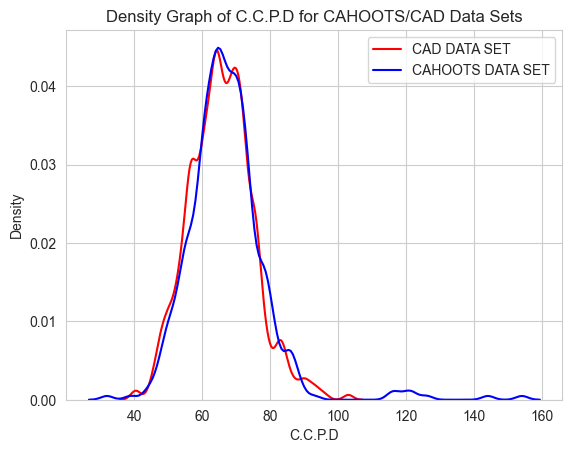

In [69]:
sns.set_style('whitegrid')
first = sns.kdeplot(np.array(pop1), bw_adjust=0.5,label="CAD DATA SET",color="red").set(xlabel="C.C.P.D", title="Density Graph of C.C.P.D for CAHOOTS/CAD Data Sets")
second = sns.kdeplot(np.array(pop2), bw_adjust=0.5, label="CAHOOTS DATA SET", color="blue").legend()


In [73]:
np.median(pop1)
np.median(pop2)

66.0

In [12]:
#cad_df w/ cahoots df
mask = (cad_df_WCH["Incident Call Time"] >= '2023-01-01 00:00:00') #only 408 calls found in the cad_16 dataset past 23-01-01
cad_df_23 = cad_df_WCH.loc[mask]
#cad_df_23
#cahoot_df
#cad_df_23

C:\Users\charl\AppData\Local\Temp\ipykernel_6892\768108441.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily_counts_cah = cah_t_df.resample("M").size()
C:\Users\charl\AppData\Local\Temp\ipykernel_6892\768108441.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily_counts_cad = cad_t_df.resample("M").size()


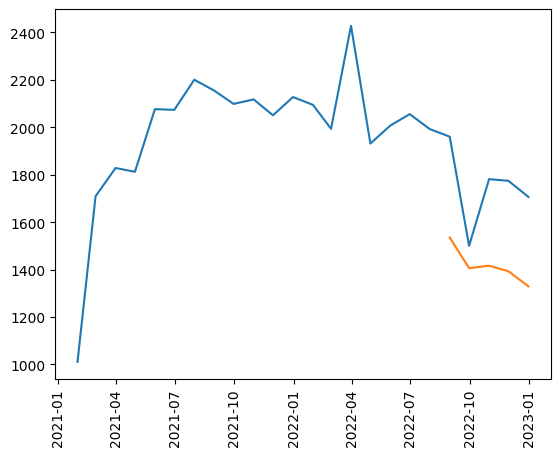

In [8]:
#cad_df with cahoots 22
#need to limit the times of bothe df's
cad_df_WCH.sort_values(by="Incident Call Time") #22-08-01 to 23 #7487 calls
cahoot_22.sort_values(by="TimeOfCall") #21-01-04 to 22-12-31 #46475
mask3 = ((cad_df_WCH["Incident Call Time"] < '2022-12-31 23:59:59'))
mask4 = (cahoot_22["TimeOfCall"] > '2022-08-01 00:00:00')
cad_df_WCH_22 = cad_df_WCH.loc[mask3]

cad_df_WCH_22.sort_values(by="Incident Call Time")
#cahoot_22_cad = cahoot_22.loc[mask4]
#cahoot_22_cad

cah_t = cahoot_22["TimeOfCall"]
cah_t_df = pd.DataFrame(data=cah_t)
cah_t_df.set_index("TimeOfCall",inplace=True)
daily_counts_cah = cah_t_df.resample("M").size()
cad_t = pd.to_datetime(cad_df_WCH_22["Incident Call Time"])
cad_t_df = pd.DataFrame(data=cad_t)
cad_t_df.set_index("Incident Call Time", inplace=True)
daily_counts_cad = cad_t_df.resample("M").size()
plt.xticks(rotation="vertical")
plt.plot(daily_counts_cah)
plt.plot(daily_counts_cad)


In [9]:
58/19566

0.002964325871409588

In [13]:
#getting all dates from 2023 from the large cad_16 dataset
cad_16["Call_Created_Time"] = pd.to_datetime(cad_16["Call_Created_Time"])
mask = (cad_16["Call_Created_Time"] >= datetime.datetime(2023,1,1))
cad_23 = cad_16.loc[mask]

len(cad_23) #179142
#cad_23


179142

In [11]:
sum(cad_23["PrimaryUnitCallSign"].isna()) #Primary unit callsign has 34871/179142 NaN
sum(cad_23["RespondingUnitCallSign"].isna()) #Responing unit callsign has 37242/179142 missing values

37242

In [12]:
sum(cad_23["Disposition"] == 'REFERRED TO OTHER AGENCY') # 4903/179142 "Reffered to other agency" 

4903

In [13]:
#cad_23["InitialIncidentTypeDescription"].unique() # CHRISTMAS LIGHT THEFT DAMAGE is a hell of a crime
#There appears to be values that include rfered to cahoots

In [14]:
#all InitialIncidentTypeDescription that directly refer to cahoots, there exists only 9  representations,
#mask2 = cad_23["InitialIncidentTypeDescription"].str.contains("CAHOOTS").fillna(False)
#cad_23[mask2]

In [15]:
#cad_23["Call_Created_Time"].hist()
#cahoot_df["Date"].hist()

In [16]:
#In this cell I will compare the 2023 CAD data from our 2 different CAD datasets, to see if I can get thoes data sets to "line up"
#cad_23_2 is the datat set with only december in 23, cad_23 is the data set for the rest of the 
#is it possible that CAHOOTS only data and EPD data are stored differently?
#************join the two data sets on the incident number feature************************
#we will then look at the data sets to hopefully identify some pattterns 

#THOUGHT: we could develop a classifier for non-cahoots/cahoots calls, the training data will be the joined cad datasets with an extra feature that is found in CAHOOTS data , this will be a binary variable.
# this would require that the cad23 data is easily identifiable in the CAHOOTS data.
#STEPTS: 
#1) ensure that the CAD data has overlap, all ID's found in one are found in the other
#2) ensure CAHOOTS data is easily identifiable in the cad23 data
#3) join all 3 data sets on the one month in december, use this joined data to train the model, with the training data coming from the overall cad data. and the classifier using the joined data to classify it
cad_ic = cad_df[["Incident Number",'Incident Call Time', 'Call Source Type', 'City',"First Dispatched Timestamp",'Nature Code', 'Full Nature Code Description', 'Assigned Unit', 'Service Type', 'Jurisidiction', 'Agency', 'First Unit Dispatched', 'Time Routed', 'Primary Unit', 'Seconds to Dispatch']]
cad_ic["First Dispatched Timestamp"]
mask3 = cad_ic["First Dispatched Timestamp"] >= datetime.datetime(2023,1,1)
cad_23_2 = cad_ic.loc[mask3]
cad_23 #these two incidencts # can be joined on 
cad_23["num"] = cad_23["IncidentNumber"].str.extract(r'([0-9]{8}$)')
in_23_2 = cad_23_2["Incident Number"]
in_23 = cad_23["num"]
diff = [] #this list will hold all IN's that are in cad_23 but not cad_23_2, or the inverse depending on the var's
simi = [] #this list will hold all IN's found in 23_2 and in 23_1
lin_2 = in_23_2.tolist()
lin_1 = in_23.tolist()
lin_1 = [int(x) for x in lin_1]
for i in lin_2:
    if i not in lin_1:
        diff.append(i)
#This does not works as len(diff) = 422 which is very signifigant because it is 1/2 of the size of 23_2
# can i make a signifigant classifier with only 422 examples? yes, even if this was 20 we could bootstrap some sample data to trian on.
# need high quality data to do this, THIS REQUIRE MAJOR TIME COMMITMENT

KeyError: "['Call Source Type', 'Nature Code', 'Full Nature Code Description', 'Jurisidiction', 'Seconds to Dispatch'] not in index"

In [ ]:
len(cahoot_df) #legth of cahoots 2023 is near 20k
cahoot_df["Reason for Dispatch"].unique()

In [ ]:
sum(cahoot_df["Reason for Dispatch"] == "Information Not Available") #4006/19570 

In [ ]:
cad_16["Call_Created_Time"][10] > datetime.datetime(2023,1,1)

In [ ]:
len(cad_df["Incident Number"])

In [ ]:
#cad_df.to_string(columns = ["Incident Call Time"])

list_date = cad_df["Incident Call Time"].astype('str').str.split()
list_date.str[0]
cad_df["Date"] = list_date.str[0]
cad_df["Time"] = list_date.str[1]
cad_df.columns # 
cad_df[cad_df["Agency"] == "CAHE"]

In [ ]:
cahoot_df["Date"] #first date is 2023-01-01
cad_df.iloc[11425:] #the number of incidents after 2023-01-01
cahoot_df["Date"].astype('str').str.split().str[0].unique()[-1]
cad_df["Date"].unique()

In [ ]:
cahoot_df.iloc[:1367] # grabs all the data up to the 25th of jan 23
#cahoot_df["Reason for Dispatch"].unique()
#it is at this point that I realized that this would be a challenge, current features to use for concordance, date/time ,Reason for Dispatch, City
#Features of the cad data that match these features: "Incident Call Time', 'First Dispatched Timestamp' (or other timestamps, maybe add the time to disptach on top of the Incident Call time.
cad_23_2

In [ ]:
#cad_df.iloc[11425:][cad_df["Assigned Unit"] == 'CAHOT ']

In [ ]:
cad_ic = cad_df[['Incident Call Time', 'Call Source Type', 'City',"First Dispatched Timestamp",'Nature Code', 'Full Nature Code Description', 'Assigned Unit', 'Service Type', 'Jurisidiction', 'Agency', 'First Unit Dispatched', 'First Dispatched Timestamp', 'Time Routed', 'Primary Unit', 'Seconds to Dispatch']]
cad_window_ic = cad_ic.iloc[11425:]
cad_window_ic[cad_window_ic["Agency"] == "CAHE"] # "Agency" = 408 w/ "CAHE" 659 w/ "EPD " which equals 1067
cad_window_ic[cad_window_ic["Assigned Unit"] == "CAHOT "] #Assigned unit with 331 tagged with "CAHOT ", 
len(cad_window_ic[cad_window_ic["Assigned Unit"] == "      "][cad_window_ic["Agency"] == "CAHE"]["Agency"]) #57 events that have blank assigned unit but "CAHE" agency tag
# 331 + 57 != 408 there is likely events tagged as "EPD " that have "Assigned Unit" be "CAHOT ",
cad_window_ic[cad_window_ic["Agency"] == "EPD "]["Assigned Unit"].unique()
#However this proves this not to be the case maybe the iverse its true? 
cad_window_ic[cad_window_ic["Assigned Unit"] == "CAHOT "][cad_window_ic["Agency"] != "CAHE"]

In [ ]:
# For data cleaning purposes, which col needs what done to it?
for i in cad_df.columns:
    print(cad_df[i].dtype,":", i)


In [ ]:
#This cell will be used to create our table of #of calls found in cad vs cahoots dataset